In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Bài 1:
Code from scratch hàm transposed convolution

In [4]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

# Bài 2:
Cho dataset cifar-10

1.Cho noise cho dataset được sample từ normal distribution (mean = 0, variance = 0.1)\
2.Dùng cấu trúc autoencoder để denoise lại bức ảnh về như ban đầu\
3.Visualize ảnh ban đầu, ảnh được thêm noise, và ảnh sau khi denoise.

In [10]:
# Define data preprocessing and loading
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
import torch.nn.functional as F
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
import torch.optim as optim

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
epochs = 10
best_accuracy = 0.0

# Training loop  
for epoch in range(epochs):
    model.train()
    train_loss=0.0
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        optimizer.zero_grad()

        # Predict the sample
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Update the parameter
        loss.backward()
        optimizer.step()

        # Keeping track the training loss
        train_loss += loss.item() 

    train_loss = train_loss / len(train_loader) 
    
    print(f'Epoch [{epoch + 1}/{epochs}]: - Train Loss:{train_loss:.4f}')

Epoch [1/10]: - Train Loss:0.8634
Epoch [2/10]: - Train Loss:0.7522
Epoch [3/10]: - Train Loss:0.6786
Epoch [4/10]: - Train Loss:0.6192
Epoch [5/10]: - Train Loss:0.5685
Epoch [6/10]: - Train Loss:0.5268
Epoch [7/10]: - Train Loss:0.4919
Epoch [8/10]: - Train Loss:0.4569
Epoch [9/10]: - Train Loss:0.4273
Epoch [10/10]: - Train Loss:0.4002


In [23]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
# Evaluation on testing dataset
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy on the test set: {accuracy:.4f}')
print(f'Recall on the test set: {recall:.4f}')
print(f'F1-score on the test set: {f1:.4f}')


Accuracy on the test set: 0.7749
Recall on the test set: 0.7749
F1-score on the test set: 0.7727


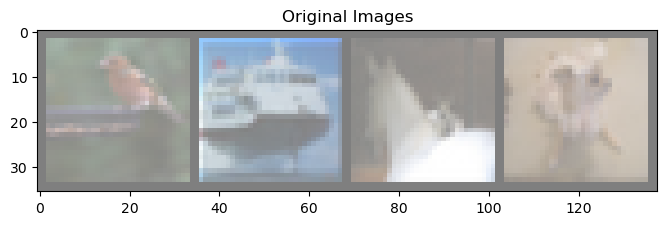

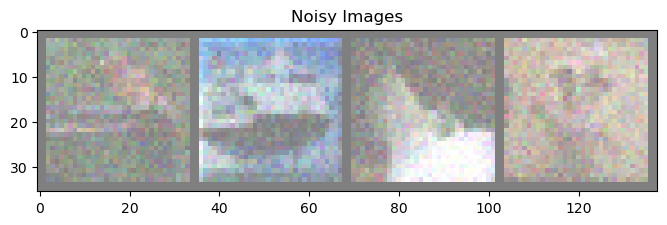

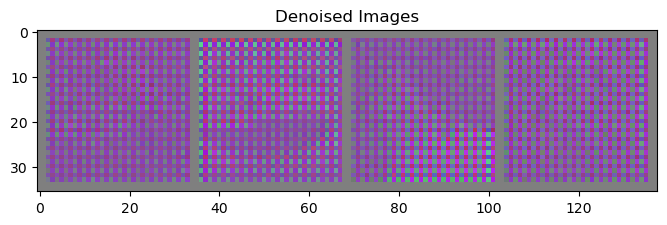

In [24]:
# Visualize ảnh ban đầu, ảnh nhiễu, và ảnh sau khi denoise
import matplotlib.pyplot as plt

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

dataiter = iter(trainloader)
images, _ = next(dataiter)
noisy_images = add_noise(images)

# Lấy một batch ảnh và thêm nhiễu
with torch.no_grad():
    denoised_images = autoencoder(noisy_images)

imshow(torchvision.utils.make_grid(images), "Original Images")
imshow(torchvision.utils.make_grid(noisy_images), "Noisy Images")
imshow(torchvision.utils.make_grid(denoised_images), "Denoised Images")

# Bài 3:
Cho dataset cifar-10

1.Giảm chiều dữ liệu về dạng 2d của 1 ảnh bất kỳ bằng 2 phương pháp: PCA và convolution AE.\
2.Visualize và so sánh 2 phương pháp

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## Giảm chiều dữ liệu bằng PCA

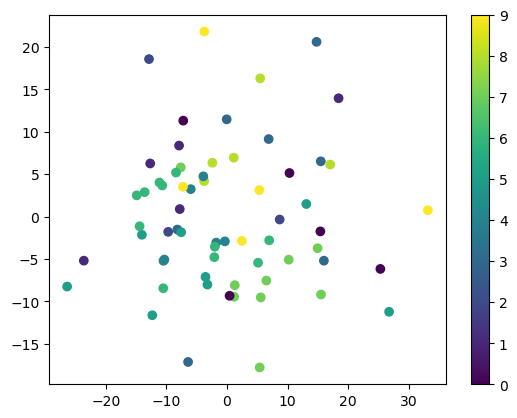

In [26]:
from sklearn.decomposition import PCA

# Lấy một batch dữ liệu CIFAR-10
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.size(0), -1)  # Đưa dữ liệu về dạng vector

# Áp dụng PCA
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(images)

# Hiển thị dữ liệu đã giảm chiều
plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=labels)
plt.colorbar()
plt.show()

## Giảm chiều dữ liệu bằng Convolutional Autoencoder (CAE)

In [29]:
import torch.nn.functional as F

# Tạo một CAE và huấn luyện nó
cae = CAE()

# Sử dụng mô hình CAE để giảm chiều dữ liệu
with torch.no_grad():
    reduced_data_cae = cae.encoder(images).view(images.size(0), -1)

# Hiển thị dữ liệu đã giảm chiều
plt.scatter(reduced_data_cae[:, 0], reduced_data_cae[:, 1], c=labels)
plt.colorbar()
plt.show()

NameError: name 'CAE' is not defined